README

* For re-training, simply run all of the cells below.   
* Our report is located at the bottom-most of the notebook. 


In [ ]:
classes_name = ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                "bus", "car", "cat", "chair", "cow", "diningtable", 
                "dog", "horse", "motorbike", "person", "pottedplant", 
                "sheep", "sofa", "train", "tvmonitor"]

In [ ]:
training_data_file = open("./datalab-2021-cup2-object-detection/pascal_voc_training_data.txt", "r")

for i, line in enumerate(training_data_file):
    if i >5:
        break
    line = line.strip()
    print(line)

000005.jpg 263 211 324 339 8 165 264 253 372 8 5 244 67 374 8 241 194 295 299 8 277 186 312 220 8
000007.jpg 141 50 500 330 6
000009.jpg 69 172 270 330 12 150 141 229 284 14 285 201 327 331 14 258 198 297 329 14
000012.jpg 156 97 351 270 6
000016.jpg 92 72 305 473 1
000017.jpg 185 62 279 199 14 90 78 403 336 12


Suggestion: Reshape images and ground truth bounding boxes' coordinates into the same size.

In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Select GPU number 1
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
# common params
IMAGE_SIZE = 448
BATCH_SIZE = 16
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

# dataset params
DATA_PATH = './datalab-2021-cup2-object-detection/pascal_voc_training_data.txt'
IMAGE_DIR = './datalab-2021-cup2-object-detection/VOCdevkit_train/VOC2007/JPEGImages/'

# model params
CELL_SIZE = 7
BOXES_PER_CELL = 2
OBJECT_SCALE = 1
NOOBJECT_SCALE = 0.5
CLASS_SCALE = 1
COORD_SCALE = 5

# training params
LEARNING_RATE = 1e-4
EPOCHS = 60

## Dataset Loader

In [ ]:
class DatasetGenerator:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self):
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        # filling the record_list
        input_file = open(DATA_PATH, 'r')

        for line in input_file:
            line = line.strip()
            ss = line.split(' ')
            self.image_names.append(ss[0])

            self.record_list.append([float(num) for num in ss[1:]])

            self.object_num_list.append(min(len(self.record_list[-1])//5, 
                                            MAX_OBJECTS_PER_IMAGE))
            if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE*5:
                # if there are objects less than MAX_OBJECTS_PER_IMAGE, pad the list
                self.record_list[-1] = self.record_list[-1] +\
                [0., 0., 0., 0., 0.]*\
                (MAX_OBJECTS_PER_IMAGE-len(self.record_list[-1])//5)
                
            elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE*5:
               # if there are objects more than MAX_OBJECTS_PER_IMAGE, crop the list
                self.record_list[-1] = self.record_list[-1][:MAX_OBJECTS_PER_IMAGE*5]

    def _data_preprocess(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(IMAGE_DIR+image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        width_ratio  = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32) 

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
        # image = (image/255) * 2 - 1
        image = image/255.0
        # image = tf.keras.applications.vgg16.preprocess_input(image)

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

        return image, labels, tf.cast(object_num, tf.int32)

    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.image_names, 
                                                      np.array(self.record_list), 
                                                      np.array(self.object_num_list)))
        dataset = dataset.shuffle(100000)
        dataset = dataset.map(self._data_preprocess, 
                              num_parallel_calls = tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(BATCH_SIZE)
        dataset = dataset.prefetch(buffer_size=200)

        return dataset

## YOLO

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
def conv_leaky_relu(inputs, filters, size, stride):
    x = layers.Conv2D(filters, size, stride, padding="same",
                      kernel_initializer=tf.keras.initializers.TruncatedNormal())(inputs)
    x = layers.LeakyReLU(0.1)(x)

    return x

In [ ]:
def vgg16_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(448, 448, 3))
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [ ]:
img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

vgg16_conv = vgg16_layers(['block5_pool'])
output_vgg16_conv = vgg16_conv(img_inputs)

x = layers.BatchNormalization()(output_vgg16_conv)

x = conv_leaky_relu(x, 512, 1, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 512, 1, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 2)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)

x = layers.BatchNormalization()(x)
x = conv_leaky_relu(x, 512, 1, 1)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 128, 1, 1)
x = conv_leaky_relu(x, 64, 1, 1)
x = conv_leaky_relu(x, 30, 1, 1)
outputs = layers.Flatten()(x)
                       
YOLO = keras.Model(inputs=img_inputs, outputs=outputs, name="YOLO")

58900480/58889256 [==============================] - 6s 0us/step


In [ ]:
YOLO.summary()

Model: "YOLO"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 448, 448, 3)]     0         
_________________________________________________________________
model (Functional)           (None, 14, 14, 512)       14714688  
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 512)       2048      
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 512)       262656    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 512)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 1024)      4719616   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 1024)      0      

### Define loss

In [ ]:
# base boxes (for loss calculation)
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

# initializtion for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [IMAGE_SIZE / CELL_SIZE * x, 
                               IMAGE_SIZE / CELL_SIZE * y, 0, 0]

base_boxes = np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4])
base_boxes = np.tile(base_boxes, [1, 1, BOXES_PER_CELL, 1])

In [ ]:
def individual_loss(args):
    predict, label, object_num = args
    results = 0.

    for j in tf.range(object_num):
        results += losses_calculation(predict, label[j:j+1, :])
    return results

In [ ]:
def yolo_loss(predicts, labels, objects_num):
    """
    Add Loss to all the trainable variables
    Args:
        predicts: 4-D tensor [batch_size, cell_size, cell_size, num_classes + 5 * boxes_per_cell]
        ===> (num_classes, boxes_per_cell, 4 * boxes_per_cell)
        labels  : 3-D tensor of [batch_size, max_objects, 5]
        objects_num: 1-D tensor [batch_size]
    """
    #you can parallel the code with tf.map_fn or tf.vectorized_map (big performance gain!)
    return tf.reduce_mean(tf.map_fn(individual_loss, elems=[predicts, labels, objects_num], fn_output_signature=tf.float32))

In [ ]:
def iou(boxes1, boxes2):
    """calculate ious
    Args:
      boxes1: 4-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]  ====> (x_center, y_center, w, h)
      boxes2: 1-D tensor [4] ===> (x_center, y_center, w, h)

    Return:
      iou: 3-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
      ====> iou score for each cell
    """

    #boxes1 : [4(xmin, ymin, xmax, ymax), cell_size, cell_size, boxes_per_cell]
    boxes1 = tf.stack([boxes1[:, :, :, 0] - boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] - boxes1[:, :, :, 3] / 2,
                      boxes1[:, :, :, 0] + boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] + boxes1[:, :, :, 3] / 2])

    #boxes1 : [cell_size, cell_size, boxes_per_cell, 4(xmin, ymin, xmax, ymax)]
    boxes1 = tf.transpose(boxes1, [1, 2, 3, 0])

    boxes2 =  tf.stack([boxes2[0] - boxes2[2] / 2, boxes2[1] - boxes2[3] / 2,
                      boxes2[0] + boxes2[2] / 2, boxes2[1] + boxes2[3] / 2])

    #calculate the left up point of boxes' overlap area
    lu = tf.maximum(boxes1[:, :, :, 0:2], boxes2[0:2])
    #calculate the right down point of boxes overlap area
    rd = tf.minimum(boxes1[:, :, :, 2:], boxes2[2:])

    #intersection
    intersection = rd - lu 

    #the size of the intersection area
    inter_square = intersection[:, :, :, 0] * intersection[:, :, :, 1]

    mask = tf.cast(intersection[:, :, :, 0] > 0, tf.float32) * tf.cast(intersection[:, :, :, 1] > 0, tf.float32)

    #if intersection is negative, then the boxes don't overlap
    inter_square = mask * inter_square

    #calculate the boxs1 square and boxs2 square
    square1 = (boxes1[:, :, :, 2] - boxes1[:, :, :, 0]) * (boxes1[:, :, :, 3] - boxes1[:, :, :, 1])
    square2 = (boxes2[2] - boxes2[0]) * (boxes2[3] - boxes2[1])

    return inter_square/(square1 + square2 - inter_square + 1e-6)

def losses_calculation(predict, label):
    """
    calculate loss
    Args:
      predict: 3-D tensor [cell_size, cell_size, num_classes + 5 * boxes_per_cell]
      label : [1, 5]  (x_center, y_center, w, h, class)
    """
    label = tf.reshape(label, [-1])

    #Step A. calculate objects tensor [CELL_SIZE, CELL_SIZE]
    #turn pixel position into cell position (corner)
    min_x = (label[0] - label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_x = (label[0] + label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_y = (label[1] - label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_y = (label[1] + label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_x = tf.floor(min_x)
    min_y = tf.floor(min_y)

    max_x = tf.minimum(tf.math.ceil(max_x), CELL_SIZE)
    max_y = tf.minimum(tf.math.ceil(max_y), CELL_SIZE)
    
    #calculate mask of object with cells
    onset = tf.cast(tf.stack([max_y - min_y, max_x - min_x]), dtype=tf.int32)
    object_mask = tf.ones(onset, tf.float32)

    offset = tf.cast(tf.stack([min_y, CELL_SIZE - max_y, min_x, CELL_SIZE - max_x]), tf.int32)
    offset = tf.reshape(offset, (2, 2))
    object_mask = tf.pad(object_mask, offset, "CONSTANT")

    #Step B. calculate the coordination of object center and the corresponding mask
    #turn pixel position into cell position (center)
    center_x = label[0] / (IMAGE_SIZE / CELL_SIZE)
    center_x = tf.floor(center_x)

    center_y = label[1] / (IMAGE_SIZE / CELL_SIZE)
    center_y = tf.floor(center_y)

    response = tf.ones([1, 1], tf.float32)

    #calculate the coordination of object center with cells
    objects_center_coord = tf.cast(tf.stack([center_y, CELL_SIZE - center_y - 1, 
                             center_x, CELL_SIZE - center_x - 1]), 
                             tf.int32)
    objects_center_coord = tf.reshape(objects_center_coord, (2, 2))

    #make mask
    response = tf.pad(response, objects_center_coord, "CONSTANT")

    #Step C. calculate iou_predict_truth [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    predict_boxes = predict[:, :, NUM_CLASSES + BOXES_PER_CELL:]

    predict_boxes = tf.reshape(predict_boxes, [CELL_SIZE, 
                                               CELL_SIZE, 
                                               BOXES_PER_CELL, 4])
    #cell position to pixel position
    predict_boxes = predict_boxes * [IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE, IMAGE_SIZE]

    #if there's no predict_box in that cell, then the base_boxes will be calcuated with label and got iou equals 0
    predict_boxes = base_boxes + predict_boxes

    iou_predict_truth = iou(predict_boxes, label[0:4])

    #calculate C tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    C = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    #calculate I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    I = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    max_I = tf.reduce_max(I, 2, keepdims=True)

    #replace large iou scores with response (object center) value
    I = tf.cast((I >= max_I), tf.float32) * tf.reshape(response, (CELL_SIZE, CELL_SIZE, 1))

    #calculate no_I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    no_I = tf.ones_like(I, dtype=tf.float32) - I

    p_C = predict[:, :, NUM_CLASSES:NUM_CLASSES + BOXES_PER_CELL]

    #calculate truth x, y, sqrt_w, sqrt_h 0-D
    x = label[0]
    y = label[1]

    sqrt_w = tf.sqrt(tf.abs(label[2]))
    sqrt_h = tf.sqrt(tf.abs(label[3]))

    #calculate predict p_x, p_y, p_sqrt_w, p_sqrt_h 3-D [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    p_x = predict_boxes[:, :, :, 0]
    p_y = predict_boxes[:, :, :, 1]

    p_sqrt_w = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 2])))
    p_sqrt_h = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 3])))

    #calculate ground truth p 1-D tensor [NUM_CLASSES]
    P = tf.one_hot(tf.cast(label[4], tf.int32), NUM_CLASSES, dtype=tf.float32)

    #calculate predicted p_P 3-D tensor [CELL_SIZE, CELL_SIZE, NUM_CLASSES]
    p_P = predict[:, :, 0:NUM_CLASSES]

    #class_loss
    class_loss = tf.nn.l2_loss(tf.reshape(object_mask, (CELL_SIZE, CELL_SIZE, 1)) * (p_P - P)) * CLASS_SCALE

    #object_loss
    object_loss = tf.nn.l2_loss(I * (p_C - C)) * OBJECT_SCALE

    #noobject_loss
    noobject_loss = tf.nn.l2_loss(no_I * (p_C)) * NOOBJECT_SCALE

    #coord_loss
    coord_loss = (tf.nn.l2_loss(I * (p_x - x)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_y - y)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_sqrt_w - sqrt_w))/IMAGE_SIZE +
                  tf.nn.l2_loss(I * (p_sqrt_h - sqrt_h))/IMAGE_SIZE) * COORD_SCALE

    return class_loss + object_loss + noobject_loss + coord_loss

## Start training

In [ ]:
dataset = DatasetGenerator().generate()

In [ ]:
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
train_loss_metric = tf.keras.metrics.Mean(name='loss')

In [ ]:
ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=YOLO)
manager = tf.train.CheckpointManager(ckpt, './ckpts/YOLO', max_to_keep=3,
                                     checkpoint_name='yolo')

ckpt.restore(manager.latest_checkpoint)

In [ ]:
@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = YOLO(image)
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
        confs = tf.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
        boxes = tf.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
        predicts = tf.concat([class_probs, confs, boxes], 3)
        loss = yolo_loss(predicts, labels, objects_num)
        train_loss_metric(loss)

    grads = tape.gradient(loss, YOLO.trainable_weights)
    optimizer.apply_gradients(zip(grads, YOLO.trainable_weights))

In [ ]:
from datetime import datetime

In [ ]:
print('{}, start training from epoch {}.'.format(datetime.now(), int(ckpt.epoch)+1))

for i in range(int(ckpt.epoch), EPOCHS):
    train_loss_metric.reset_states()
    ckpt.epoch.assign_add(1)

    for idx, (image, labels, objects_num) in enumerate(dataset):
        train_step(image, labels, objects_num)

    print('{}, Epoch {}: loss {:.2f}'.format(datetime.now(), i+1, train_loss_metric.result()))

    save_path = manager.save()
    print('Saved checkpoint for epoch {}: {}'.format(int(ckpt.epoch), save_path))

## Non-Max Suppresion

In [ ]:
def process_predicts(outputs, thresh=0.12):
    """
    process the predicts of object detection with one image input.

    Args:
        resized_img: resized source image.
        predicts: output of the model.
        thresh: thresh of bounding box confidence.
    Return:
        predicts_dict: {"cat": [[x1, y1, x2, y2, scores1], [...]]}.
    """
    
    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
    confs = np.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
    boxes = np.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
    predicts = np.concatenate([class_probs, confs, boxes], 3)
    
    p_classes = predicts[0, :, :, 0:20] # 20 classes.
    C = predicts[0, :, :, 20:22] # two bounding boxes in one cell.
    coordinate = predicts[0, :, :,22:] # all bounding boxes position.

    p_classes = np.reshape(p_classes, (7, 7, 1, 20))
    C = np.reshape(C, (7, 7, 2, 1))

    P = C * p_classes # confidencefor all classes of all bounding boxes (cell_size, cell_size, bounding_box_num, class_num) = (7, 7, 2, 1).

    predicts_dict = {}
    for i in range(7):
        for j in range(7):
            temp_data = np.zeros_like(P, np.float32)
            temp_data[i, j, :, :] = P[i, j, :, :]
            position = np.argmax(temp_data) # refer to the class num (with maximum confidence) for every bounding box.
            index = np.unravel_index(position, P.shape)

            if P[index] > thresh:
                class_num = index[-1]
                coordinate = np.reshape(coordinate, (7, 7, 2, 4)) # (cell_size, cell_size, bbox_num_per_cell, coordinate)[xmin, ymin, xmax, ymax]
                max_coordinate = coordinate[index[0], index[1], index[2], :]

                xcenter = max_coordinate[0]
                ycenter = max_coordinate[1]
                w = max_coordinate[2]
                h = max_coordinate[3]

                xcenter = (index[1] + xcenter) * (448/7.0)
                ycenter = (index[0] + ycenter) * (448/7.0)

                w = w * 448 
                h = h * 448
                xmin = 0 if (xcenter - w/2.0 < 0) else (xcenter - w/2.0)
                ymin = 0 if (ycenter - h/2.0 < 0) else (ycenter - h/2.0)
                xmax = IMAGE_SIZE if (xmin + w) > IMAGE_SIZE else (xmin + w)
                ymax = IMAGE_SIZE if (ymin + h) > IMAGE_SIZE else (ymin + h)

                predicts_dict.setdefault(class_num, [])
                predicts_dict[class_num].append([int(xmin), int(ymin), int(xmax), int(ymax), P[index]])
                
    if predicts_dict == {}:
        #choose the most confidence one
        max_conf = np.max(P)
        index = np.argmax(P)

        index = np.unravel_index(index, P.shape)

        class_num = index[3]

        coordinate = np.reshape(coordinate, 
                            (CELL_SIZE, 
                             CELL_SIZE,
                             BOXES_PER_CELL, 
                             4))

        max_coordinate = coordinate[index[0], index[1], index[2], :]

        xcenter = max_coordinate[0]
        ycenter = max_coordinate[1]
        w = max_coordinate[2]
        h = max_coordinate[3]

        xcenter = (index[1] + xcenter) * (IMAGE_SIZE/float(CELL_SIZE))
        ycenter = (index[0] + ycenter) * (IMAGE_SIZE/float(CELL_SIZE))

        w = w * IMAGE_SIZE
        h = h * IMAGE_SIZE

        xmin = xcenter - w/2.0
        ymin = ycenter - h/2.0

        xmax = xmin + w
        ymax = ymin + h
        # class_name = classes_name[class_num]
        predicts_dict[class_num] = [[int(xmin), int(ymin), int(xmax), int(ymax), P[index]]]
        
    return predicts_dict


def non_max_suppress(predicts_dict, threshold=0.5):
    """
    implement non-maximum supression on predict bounding boxes.
    Args:
        predicts_dict: {"cat": [[x1, y1, x2, y2, scores1], [...]]}.
        threshhold: iou threshold
    Return:
        predicts_dict processed by non-maximum suppression
    """
    for object_name, bbox in predicts_dict.items():
        bbox_array = np.array(bbox, dtype=np.float)
        x1, y1, x2, y2, scores = bbox_array[:,0], bbox_array[:,1], bbox_array[:,2], bbox_array[:,3], bbox_array[:,4]
        areas = (x2-x1+1) * (y2-y1+1)
        #print "areas shape = ", areas.shape
        order = scores.argsort()[::-1]
        #print "order = ", order
        keep = []

        while order.size > 0:
            i = order[0]
            keep.append(i)
            xx1 = np.maximum(x1[i], x1[order[1:]])
            yy1 = np.maximum(y1[i], y1[order[1:]])
            xx2 = np.minimum(x2[i], x2[order[1:]])
            yy2 = np.minimum(y2[i], y2[order[1:]])

            inter = np.maximum(0.0, xx2-xx1+1) * np.maximum(0.0, yy2-yy1+1)
            iou = inter/(areas[i]+areas[order[1:]]-inter)
            indexs = np.where(iou<=threshold)[0]
            order = order[indexs+1]
        bbox = bbox_array[keep]
        predicts_dict[object_name] = bbox.tolist()
        predicts_dict = predicts_dict
    return predicts_dict

### Build test data iterator

In [ ]:
test_img_files = open('./datalab-2021-cup2-object-detection/pascal_voc_testing_data.txt')
test_img_dir = './datalab-2021-cup2-object-detection/VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = image/255.0


    return image_name, image, h, w

test_dataset = test_dataset.map(load_img_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32)

In [ ]:
ckpt = tf.train.Checkpoint(net=YOLO)
ckpt.restore(manager.latest_checkpoint)

In [ ]:
@tf.function
def prediction_step(img):
    return YOLO(img, training=False)

### Make predictions and output to txt file

In [ ]:
output_file = open('./test_prediction.txt', 'w')

for img_name, test_img, img_h, img_w in test_dataset:
    batch_num = img_name.shape[0]
    for i in range(batch_num):
        # xmin, ymin, xmax, ymax, class_num, conf = process_outputs(prediction_step(test_img[i:i+1]))
        y_pred = process_predicts(prediction_step(test_img[i:i+1]), thresh=0.05)
        # print(y_pred)
        y_pred = non_max_suppress(y_pred, threshold=0.2)
        # print(y_pred)
        output_file.write(img_name[i:i+1].numpy()[0].decode('ascii'))
        for class_num in y_pred.keys():
            for idx, box in enumerate(y_pred[class_num]):
                output_file.write(' %d %d %d %d %d %f' % 
                              (box[0]*(img_w[i:i+1]/IMAGE_SIZE), box[1]*(img_h[i:i+1]/IMAGE_SIZE), box[2]*(img_w[i:i+1]/IMAGE_SIZE), box[3]*(img_h[i:i+1]/IMAGE_SIZE), class_num, box[4]))
        output_file.write('\n')
        #         y_pred[class_num][idx] = [box[0]*(img_w[i:i+1]/IMAGE_SIZE), box[1]*(img_h[i:i+1]/IMAGE_SIZE), box[2]*(img_w[i:i+1]/IMAGE_SIZE), box[3]*(img_h[i:i+1]/IMAGE_SIZE), box[4]]
        # xmin, ymin, xmax, ymax = xmin*(img_w[i:i+1]/IMAGE_SIZE), ymin*(img_h[i:i+1]/IMAGE_SIZE), xmax*(img_w[i:i+1]/IMAGE_SIZE), ymax*(img_h[i:i+1]/IMAGE_SIZE)

        #img filename, xmin, ymin, xmax, ymax, class, confidence
        # output_file.write(img_name[i:i+1].numpy()[0].decode('ascii')+" %d %d %d %d %d %f\n" %(xmin, ymin, xmax, ymax, class_num, conf))

output_file.close()

KeyboardInterrupt: 

### Run evaluation metric

In [ ]:
import sys
sys.path.insert(0, './datalab-2021-cup2-object-detection/evaluate')

In [ ]:
import evaluate
import os
os.chdir('./datalab-2021-cup2-object-detection')
#evaluate.evaluate("input prediction file name", "desire output csv file name")
evaluate.evaluate('../test_prediction.txt', './output_file.csv')
os.chdir('..')

End Evalutation


## Visualization

In [ ]:
import matplotlib.pyplot as plt
import cv2

In [ ]:
def draw_rect(im, cords, color=(0,255,255)):
    
    # im = im.copy()
    
    cords = cords[:,:4]
    cords = cords.reshape(-1,4)
    if not color:
        color = [255,255,255]
    for cord in cords:
        
        pt1, pt2 = (cord[0], cord[1]) , (cord[2], cord[3])
                
        pt1 = int(pt1[0]), int(pt1[1])
        pt2 = int(pt2[0]), int(pt2[1])
    
        cv2.rectangle(im, pt1, pt2, color, 2)

{7: [[97, 82, 215, 252, 0.09703345], [159, 81, 293, 270, 0.15325952], [229, 103, 342, 239, 0.14527997], [71, 82, 368, 351, 0.3260151], [187, 183, 375, 361, 0.08954312]]}
{7: [[71.0, 82.0, 368.0, 351.0, 0.3260151147842407]]}


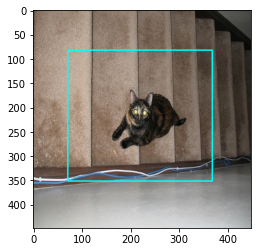

In [ ]:
np_img = cv2.imread('./datalab-2021-cup2-object-detection/VOCdevkit_test/VOC2007/JPEGImages/000049.jpg')
# np_img = cv2.imread('./datalab-2021-cup2-object-detection/VOCdevkit_train/VOC2007/JPEGImages/000005.jpg')
resized_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
resized_img = np_img
np_img = np_img.astype(np.float32)
# np_img = np_img / 255.0 * 2 - 1
np_img = np_img / 255.0
# np_img = tf.keras.applications.vgg16.preprocess_input(np_img)
np_img = np.reshape(np_img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))

y_pred = YOLO(np_img, training=False)
# predicts_dict = process_predicts(np_img, prediction_step(np_img), thresh=0.05)
predicts_dict = process_predicts(y_pred, thresh=0.05)
print(predicts_dict)
predicts_dict = non_max_suppress(predicts_dict, threshold=0.1)
print(predicts_dict)
for class_name in predicts_dict.keys():
    box = np.array(predicts_dict[class_name])
    draw_rect(resized_img, box)

# xmin, ymin, xmax, ymax, class_num, conf = process_outputs(y_pred)
# cv2.rectangle(resized_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 255), 3)
# cv2.putText(resized_img, class_name, (0, 200), 2, 1.5, (0, 255, 255), 2)
# print(bounding_boxes)
# draw_rect(resized_img, bounding_boxes[:,:4])
plt.imshow(resized_img)
plt.show()

COMPETITION 02 REPORT

A. What kind of models we have tried and how did they work?
*   Initially, we used the YOLO model provided by TA. The results were not satisfying as the loss was high.
*  We tried to build upon YOLO v2 by adding batch normalization and full CNN. Consequently, the loss could drop significantly compared to the initial one. 

B. Anything we've done and want to tell you?
*   We replaced the the initial layers of YOLO to a pretrained model (VGG16).
*   Modified the given code from TA to detect multiple objects in an image.

C. What problems occurred and how did you solve them?
*   Long training time.
*   We leveraged fully convolutional layer to reduce the parameters significantly.

